In [ ]:
# !apt-get install -y xvfb python-opengl > /dev/null 2>&1
# !pip install gym pyvirtualdisplay > /dev/null 2>&1

from google.colab import drive
drive.mount('/content/drive')

import gym
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import random
import pickle
import time
import cv2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = [None] * max_size
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = random.sample(range(self.size), batch_size)
        return [self.buffer[index] for index in indices]

In [ ]:
class Model:
    def __init__(self, frame_size, num_actions):
        self.model = keras.Sequential()
        self.model.add(keras.layers.Dense(512, activation = 'relu', input_shape = (frame_size*128, )))
        self.model.add(keras.layers.Dense(256, activation = 'relu'))
        self.model.add(keras.layers.Dense(128, activation = 'relu'))
        self.model.add(keras.layers.Dense(num_actions))
        self.model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.00001), loss = 'mse', metrics = ['accuracy'])
        self.model.summary()

In [ ]:
class Agent:
    def __init__(self, agent_params):
        self.discount = agent_params['discount']
        self.epsilon = agent_params['epsilon']
        self.num_actions = agent_params['num_actions']
        self.exp_size = agent_params['exp_size']
        self.frame_size = agent_params['frame_size']
        self.merge = agent_params['merge_threshold']
        self.batch_size = agent_params['batch_size']
        self.last_action = None
        self.last_state = None
        self.exp = ReplayMemory(self.exp_size)
        self.frames = np.zeros((1, self.frame_size*128))
        self.target_model = Model(self.frame_size, self.num_actions)
        self.value_model = Model(self.frame_size, self.num_actions)
        self.num_updates = 0
        self.num_steps = 0
        self.num_games = 0
        self.num_merge = 0
        self.waste = 0
        self.lives = agent_params['lives']
        self.target_model.model.set_weights(self.value_model.model.get_weights())
  
    def phi(self, state):
        new = self.frames[:, 128:].copy()
        new = np.concatenate([new, state/255.0], axis = -1)
        self.frames = new.copy()
        return self.frames
    
    def phi_init(self):
        self.frames = np.zeros((1, self.frame_size*128))

    def run(self):
        updates = min(self.batch_size, self.exp.size)
        self.num_updates += updates
        batch = self.exp.sample(updates)

        input = [x[0] for x in batch]
        inp = [x[3] for x in batch]
        x_train = np.concatenate(input, axis = 0)
        y_train = self.value_model.model.predict(x_train)
        target_action = np.argmax(y_train, axis = 1)
        x_target = np.concatenate(inp, axis = 0)
        y_target = self.target_model.model.predict(x_target)

        for count, memory in enumerate(batch):
            last_state, last_action, reward, state, terminal = memory
            y_train[count][last_action] = reward + self.discount*y_target[count][target_action[count]]*(1 - terminal)

        self.value_model.model.fit(x_train, y_train, verbose = 0, epochs = 1)

        if self.num_steps % self.merge == 0:
            self.merge_model()

    def merge_model(self):
        self.target_model.model.set_weights(self.value_model.model.get_weights())
        self.num_merge += 1

    def epsilon_decay(self):
        if self.epsilon >= 0.05:
            if self.num_steps >= 50000:
                if self.num_steps <= 1050000:
                    self.epsilon -= 0.9/1000000
                elif self.num_steps <= 2050000:
                    self.epsilon -= 0.05/1000000

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            action = np.argmax(self.value_model.model.predict(state)[0])

        self.num_steps += 1
        self.epsilon_decay()
        return action

    def agent_start(self, env_state):
        self.lives = 5
        self.phi_init()
        state = self.phi(env_state)
        self.last_action = self.choose_action(state)
        self.last_state = state
        return self.last_action

    def agent_step(self, reward, env_state, lives):
        state = self.phi(env_state)
        if self.waste:
            self.waste = 0
        elif self.lives > lives:
            self.lives = lives
            memory = (self.last_state, self.last_action, reward, state, 1)
            self.phi_init()
            self.exp.append(memory)
        else:
            memory = (self.last_state, self.last_action, reward, state, 0)
            self.exp.append(memory)
        self.run()
        self.last_action = self.choose_action(state)
        self.last_state = state
        return self.last_action

    def agent_end(self, reward):
        memory = (self.last_state, self.last_action, reward, np.zeros((1, 512)), 1)
        self.exp.append(memory)
        self.run()
        self.num_games += 1

    def plot(self, states):
        y = np.mean(np.max(self.value_model.model.predict(states), axis = 1))
        return y

In [ ]:
agent_params = {
    'discount' :0.99,
    'epsilon' :1.0,
    'num_actions' : 4,
    'exp_size': 600000,
    'frame_size' : 4,
    'merge_threshold' : 10000,
    'batch_size' : 32,
    'lives' : 5
}
agent = Agent(agent_params)
episodes = []
q_value = []
avg_reward = []

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 516       
Total params: 427,396
Trainable params: 427,396
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               262656    
__________________________

In [ ]:
env = gym.make('Breakout-ramDeterministic-v4')
print(env.action_space)

Discrete(4)


In [ ]:
indices = np.random.choice(1, 20000)
test_states = np.zeros((20000, 512))
for count, index in enumerate(indices):
    test_states[count, :] = agent.exp.buffer[index]

In [ ]:
def train(agent, env):
    num_games = 1000
    total = 0
    sum = 0
    for _ in range(1, num_games+1):
        # fourcc = cv2.VideoWriter_fourcc(*'XVID')
        # out = cv2.VideoWriter('/content/drive/My Drive/output' + str(_) + '.avi',fourcc,20, (160, 210))   
        action = agent.agent_start(env.reset().reshape((1, 128)))
        observations, reward, done, info = env.step([action])
        # image = env.unwrapped._get_image()
        # image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
        # out.write(image)
        total += reward
        sum += reward

        while not done:
            observations, reward, done, info = env.step([agent.agent_step(reward, observations.reshape((1, 128)), env.ale.lives())])
            # image = env.unwrapped._get_image()
            # image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
            # out.write(image)
            total += reward
            sum += reward
        agent.agent_end(reward)

        if agent.num_games % 50 == 0:
            episodes.append(agent.num_games)
            q_value.append(agent.plot(test_states))
            avg_reward.append(total/50)
            total = 0

        if agent.num_games % 100 == 0:
            print('Games = {}, Steps = {}, Reward = {}'.format(_, agent.num_steps, sum/100))
            sum = 0
    
        if agent.num_games % 400 == 0:
            with open('/content/drive/My Drive/DQN/episodes2.pkl', 'wb') as f:
                pickle.dump(episodes, f)
            with open('/content/drive/My Drive/DQN/q_value2.pkl', 'wb') as f:
                pickle.dump(q_value, f)
            with open('/content/drive/My Drive/DQN/avg_reward2.pkl', 'wb') as f:
                pickle.dump(avg_reward, f)
            with open('/content/drive/My Drive/DQN/test_states2.pkl', 'wb') as f:
                pickle.dump(test_states, f)
            with open('/content/drive/My Drive/DQN/agent2.pkl', 'wb') as f:
                pickle.dump(agent, f)
        elif agent.num_games % 200 == 0:
            with open('/content/drive/My Drive/DQN/episodes3.pkl', 'wb') as f:
                pickle.dump(episodes, f)
            with open('/content/drive/My Drive/DQN/q_value3.pkl', 'wb') as f:
                pickle.dump(q_value, f)
            with open('/content/drive/My Drive/DQN/avg_reward3.pkl', 'wb') as f:
                pickle.dump(avg_reward, f)
            with open('/content/drive/My Drive/DQN/test_states3.pkl', 'wb') as f:
                pickle.dump(test_states, f)
            with open('/content/drive/My Drive/DQN/agent3.pkl', 'wb') as f:
                pickle.dump(agent, f)

In [ ]:
train(agent, env)

Games = 100, Steps = 12108998, Reward = 66.07
Games = 200, Steps = 12215838, Reward = 58.97
Games = 300, Steps = 12331134, Reward = 81.85
Games = 400, Steps = 12444458, Reward = 64.12
Games = 500, Steps = 12565582, Reward = 73.03
Games = 600, Steps = 12674746, Reward = 57.68
Games = 700, Steps = 12724836, Reward = 23.47
Games = 800, Steps = 12815720, Reward = 52.99
Games = 900, Steps = 12928602, Reward = 71.26
Games = 1000, Steps = 13025240, Reward = 64.72


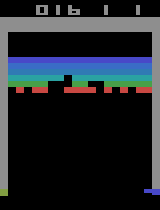

(210, 160, 3)


In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(env.unwrapped._get_image())
print(env.unwrapped._get_image().shape)

In [ ]:
with open('/content/drive/My Drive/DQN/agent2.pkl', 'rb') as f:
    agent = pickle.load(f)
with open('/content/drive/My Drive/DQN/episodes2.pkl', 'rb') as f:
    episodes = pickle.load(f)
with open('/content/drive/My Drive/DQN/q_value2.pkl', 'rb') as f:
    q_value = pickle.load(f)
with open('/content/drive/My Drive/DQN/avg_reward2.pkl', 'rb') as f:
    avg_reward = pickle.load(f)
with open('/content/drive/My Drive/DQN/test_states2.pkl', 'rb') as f:
    test_states = pickle.load(f)

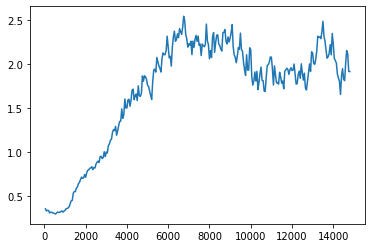

In [ ]:
plt.plot(episodes, q_value)
plt.show()

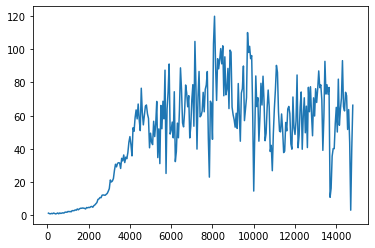

In [ ]:
plt.plot(episodes, avg_reward)
plt.show()

In [ ]:
print(agent.num_games)
print(agent.num_steps)
print(agent.epsilon)
print(np.max(agent.value_model.model.get_weights()[0]))

15000


In [ ]:
class Performer:
    def __init__(self, performer_params):
        self.num_actions = performer_params['num_actions']
        self.frame_size = performer_params['frame_size']
        self.last_action = None
        self.frames = np.zeros((1, self.frame_size*128))
        self.predict_model = Model(self.frame_size, self.num_actions)
        self.num_steps = 0
        self.lives = agent_params['lives']
        self.epsilon = performer_params['epsilon']
  
    def phi(self, state):
        new = self.frames[:, 128:].copy()
        new = np.concatenate([new, state/255.0], axis = -1)
        self.frames = new.copy()
        return self.frames
    
    def phi_init(self):
        self.frames = np.zeros((1, self.frame_size*128))

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            action = np.argmax(self.predict_model.model.predict(state)[0])
        self.num_steps += 1
        return action

    def agent_start(self, env_state):
        self.lives = 5
        self.phi_init()
        state = self.phi(env_state)
        self.last_action = self.choose_action(state)
        return self.last_action

    def agent_step(self, reward, env_state, lives):
        state = self.phi(env_state)
        if self.lives > lives:
            self.lives = lives
            self.phi_init()
        self.last_action = self.choose_action(state)
        return self.last_action

In [ ]:
performer = Performer(performer_params = {'num_actions' : 4, 'frame_size'  : 4, 'lives' : 5, 'epsilon' : 0.05})

In [ ]:
performer.predict_model.model.set_weights(agent.target_model.model.get_weights())

In [ ]:
def perform(performer, env):
    num_games = 20
    for i in range(1, num_games+1):
        total = 0
        action = performer.agent_start(cv2_imshow(env.reset())env.reset().reshape((1, 128)))
        observations, reward, done, info = env.step([action])
        total += reward

        while not done:
            observations, reward, done, info = env.step([performer.agent_step(reward, observations.reshape((1, 128)), env.ale.lives())])
            total += reward
        print('Game {}, Score = {}, Steps = {}'.format(i, total, performer.num_steps))

In [ ]:
perform(performer, env)

Game 1, Score = 136.0, Steps = 1702
Game 2, Score = 37.0, Steps = 2334
Game 3, Score = 95.0, Steps = 3632
Game 4, Score = 60.0, Steps = 4650
Game 5, Score = 64.0, Steps = 5691
Game 6, Score = 105.0, Steps = 7228
Game 7, Score = 207.0, Steps = 8614
Game 8, Score = 75.0, Steps = 9928
Game 9, Score = 91.0, Steps = 11443
Game 10, Score = 71.0, Steps = 12500
Game 11, Score = 58.0, Steps = 13654
Game 12, Score = 75.0, Steps = 14943
Game 13, Score = 82.0, Steps = 16323
Game 14, Score = 313.0, Steps = 17909
Game 15, Score = 51.0, Steps = 19092
Game 16, Score = 93.0, Steps = 20596
Game 17, Score = 107.0, Steps = 21692
Game 18, Score = 82.0, Steps = 22806
Game 19, Score = 83.0, Steps = 24206
Game 20, Score = 79.0, Steps = 25475
